### 1. 原理

### 2. 代码

In [15]:
import collections
import random
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
from GridWorld import GridWorld

In [16]:
# 创建一个网格世界
rows = 5
columns = 5

n_states = rows * columns
# (up, down, left, right, stay)
n_actions = 5 

gridworld  = GridWorld(forbiddenAreaReward=-10, reward=1, desc=[".....", ".##..", "..#..", ".#T#.", ".#..."])
print('Initial Grid World')
gridworld.show()

Initial Grid World
⬜️⬜️⬜️⬜️⬜️
⬜️🚫🚫⬜️⬜️
⬜️⬜️🚫⬜️⬜️
⬜️🚫✅🚫⬜️
⬜️🚫⬜️⬜️⬜️


In [17]:
# 创建经验池
# 我们可以利用队列的特点，先进先出，来实现经验池，最大容量通过capacity来控制

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)
    
    # 根据算法，我们需要存储的经验是(state, action, reward, next_state, done)
    # 在Q-learning的算法中，next_action是不需要的
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    # 定义采样，DQN算法中，我们是随机采样出batch_size个经验
    def sample(self, batch_size):
        # 随机采样batch_size个经验
        transitions = random.sample(self.buffer, batch_size)
        # 将state, action, reward, next_state, done分别存储在不同的列表中
        state, action, reward, next_state, done = zip(*transitions)
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [18]:
# 根据DQN的算法，我们需要两个网络，一个是Q网络，一个是target网络
# Q网络和target网络的结构是一样的
# Q网络即是在目标函数当中减去的那个Q_hat_(s, a)网络
# 创建Q网络: 输入是状态，输出是每个动作的Q值,这个是原始论文的实现，而不是B站视频中提到的方法
class Net(nn.Module):
    def __init__(self, n_states, n_hidden, n_actions):
        '''
        n_states: 状态数
        n_hidden: 隐藏层神经元个数
        n_actions: 动作数
        '''
        super().__init__()
        # (batch_size, n_states) -> (batch_size, n_hidden)
        self.fc1 = nn.Linear(n_states, n_hidden)
        # (batch_size, n_hidden) -> (batch_size, n_actions)
        self.fc2 = nn.Linear(n_hidden, n_actions)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# 创建DQN网络
class DQN:
    def __init__(self,
                n_states, # 共有多少个状态
                n_hidden, # 深度神经网络的隐藏层神经元个数
                n_actions, # 动作数
                learning_rate,
                gamma,
                epsilon,
                target_update,
                device):
        self.n_states = n_states
        self.n_hidden = n_hidden
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.device = device
        # 设置一个计数器，用于计算更新target网络的次数
        self.count = 0

        # 创建Q网络
        self.q_net = Net(self.n_states, self.n_hidden, self.n_actions).to(self.device)

        # target网络
        self.target_net = Net(self.n_states, self.n_hidden, self.n_actions).to(self.device)

        # 优化器，更新训练网络的参数
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=self.learning_rate)
        
    def take_action(self, state):
        # 因为后面要将state输入到神经网络中，所以需要将state转换为tensor，并且扩充维度
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        # epsilon-greedy策略, 我们按照视频中的定义法来写
        action_values = self.q_net(state)
        # (1 - epsilon / len(action_space))的概率随机选择动作
        # (1 - epsilon / len(action_space)(len(action_space) - 1)) 选择最大的动作
        greedy_action =  action_values.argmax().item()

        random_prob = self.epsilon / self.n_actions

        epsilon_greedy_prob = 1 - random_prob * (self.n_actions - 1)

        probabilitiy = [random_prob] * self.n_actions
        probabilitiy[greedy_action] = epsilon_greedy_prob

        action = np.random.choice(np.arange(self.n_actions), p=probabilitiy)

        return action
    
    # 网络训练
    def update(self, transition_dict):
        # transtion_dict是一个字典，包含了state, action, reward, next_state, done
        # 获取状态：shape为(batch_size, n_states)
        state = torch.tensor(transition_dict['state'], dtype=torch.float32).to(self.device)
        # 获取动作：shape为(batch_size, )，扩充维度：(batch_size, 1)
        action = torch.tensor(transition_dict['action'], dtype=torch.long).to(self.device).unsqueeze(1)
        # 获取奖励：shape为(batch_size, )，扩充维度：(batch_size, 1)
        reward = torch.tensor(transition_dict['reward'], dtype=torch.float32).to(self.device).unsqueeze(1)
        # 获取下一个状态：shape为(batch_size, n_states)
        next_state = torch.tensor(transition_dict['next_state'], dtype=torch.float32).to(self.device)
        # 获取done：shape为(batch_size, )，扩充维度：(batch_size, 1)
        dones = torch.tensor(transition_dict['done'], dtype=torch.float32).to(self.device).unsqueeze(1)

        # 计算Q(s, a)， q_net 的输出是(batch_size, n_actions)，代表在当前状态下，每个动作的Q值
        # action 是经验中采取的动作，使用gather函数可以将对应状态下采取的动作的Q值取出来
        # 因为这里的state和action是在replaybuffer当中按照batch_size采样出来的
        # 他们实际上都被分别存储在一个列表中，所以我们可以直接使用gather函数来取出对应的Q值
        q_values = self.q_net(state).gather(1, action)

        # 使用target网络来计算Q_hat_(s', a')，target_net的输出是(batch_size, n_actions)，代表在下一个状态下，每个动作的Q值
        # 我们需要取出在下一个状态下，最大的Q值，所以使用max函数
        # shape: (batch_size, n_actions) -> (batch_size, 1)
        max_next_q_values = self.target_net(next_state).max(dim=1, keepdim=True)[0]
        # 计算Q_hat_(s', a'),dones是一个bool值，如果done为True，那么我们就不需要计算下一个状态的Q值
        q_targets = reward + self.gamma * max_next_q_values * (1 - dones)

        # 计算损失,求expectation，公式在书中P202
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))

        # 梯度清零
        self.optimizer.zero_grad()
        # 反向传播
        dqn_loss.backward()
        # 更新参数
        self.optimizer.step()

        # 每隔一定的步数，更新target网络
        if self.count % self.target_update == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        self.count += 1

    def get_q_values(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.q_net(state)
        return q_values.cpu().numpy()

In [19]:
## 设置超参数
# 经验池容量大小
replay_buffer_size = 500
# 学习率
lr = 2e-3
# 折扣因子
gamma = 0.9
# epsilon的初始值
epsilon = 0.9
# target net更新频率
target_update = 200
# batch size
batch_size = 32
# 隐藏层神经元个数
hidden_dim = 256
# 经验池最小容量，即经验池中至少有多少条经验时，才开始训练
min_pool_size = 200
# 设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 实例化replay buffer
replay_buffer = ReplayBuffer(replay_buffer_size)
# 实例化 DQN 网络
agent = DQN(
    n_states=n_states,
    n_hidden=hidden_dim,
    n_actions=n_actions,
    learning_rate=lr,
    gamma=gamma,
    epsilon=epsilon,
    target_update=target_update,
    device=device
)

100%|██████████| 4000/4000 [00:07<00:00, 562.30it/s]


训练结束！


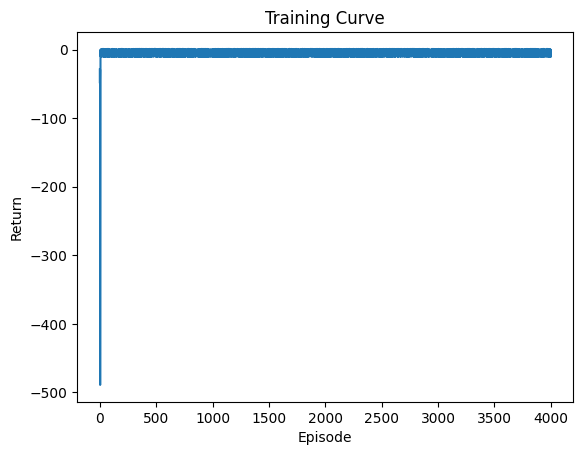

In [20]:
## 开始训练
### 训练100个episode
# 记录每个episode的reward
return_list = []
# 初始化state value

for episode in tqdm(range(4000)):
    # 记录每个episode的reward
    episode_reward = 0
    # 是否到达终点
    done = False
    # 初始化开始状态, nowstate是一个整数，代表当前状态
    # state是一个one-hot向量，代表当前状态矩阵
    nowstate = gridworld.reset()
    state = [0] * n_states
    state[nowstate] = 1

    while True:
        # 获取当前状态下要采取的动作
        action = agent.take_action(state)
        # 与环境交互，获取下一个状态，奖励，是否结束
        next_state, reward, done = gridworld.getScore(nowstate, action)

        nowstate = next_state
        # 将next_state转换为one-hot向量
        next_state = [0] * n_states
        next_state[nowstate] = 1
        # 将经验存储到经验池中
        replay_buffer.add(state, action, reward, next_state, done)
        # 更新状态
        state = next_state

        # 记录每个episode的reward
        episode_reward += reward
        # 如果经验池中的经验数量大于min_pool_size，那么开始训练

        if len(replay_buffer) > min_pool_size:
            # 从经验池中采样出batch_size个经验
            state, action, reward, next_state, done = replay_buffer.sample(batch_size)
            # 将经验存储在字典中
            transition_dict = {
                'state': state,
                'action': action,
                'reward': reward,
                'next_state': next_state,
                'done': done
            }
            # 更新网络
            agent.update(transition_dict)

        if done:
            break
    return_list.append(episode_reward)


print('训练结束！')
# 绘制reward曲线
plt.plot(return_list)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Training Curve')
plt.show()

In [22]:
# 可视化最优策略
states = torch.tensor(np.eye(n_states, n_states), dtype=torch.float32).to(device)
q_values = agent.get_q_values(states).squeeze(axis=0)
optimal_actions = q_values.argmax(axis=1)
print('Optimal Actions:')
gridworld.show_policy_list(optimal_actions)

Optimal Actions:
现在的策略是：
➡️➡️➡️➡️⬇️
⬆️⏫️⏩️➡️⬇️
⬆️⬅️⏬➡️⬇️
⬆️⏩️✅⏪⬇️
⬆️⏩️⬆️⬅️⬅️


C:\Users\callmest\AppData\Local\Temp\ipykernel_96280\381323720.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
